In [ ]:
import piplite
await piplite.install(['ipywidgets'])
await piplite.install(['jsonpickle'])
await piplite.install(['scipy'])
await piplite.install(['matplotlib'])
await piplite.install(['numpy'])
await piplite.install(['ipympl'])
from scipy.stats import norm
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
import ipywidgets as widgets
import jsonpickle
import random
%matplotlib widget

random.seed()

In [2]:
## Define Supply and Demand Curves
class SupplyCurve:
    def __init__(self, b, q_e, p_e, C_f):
        self.b = b
        self.q_e = q_e
        self.p_e = p_e
        self.C_f = C_f

        self.updated = False

    def deltaSupplyCurve(self, supplyCurve, scalar):
        a = 1 / self.b
        delta_a = 1 / supplyCurve.b

        b_new = 1 / (a + (scalar) * delta_a)
        q_e_new = (a * self.q_e + (scalar) * (delta_a + supplyCurve.q_e) / (a + (scalar) * delta_a))
        p_e_new = (a * delta_a) / (a + scalar * delta_a) * (self.q_e - supplyCurve.q_e) ** 2 + self.p_e + scalar * supplyCurve.p_e
        C_f_new = self.C_f + supplyCurve.C_f

        self.b = b_new 
        self.q_e = q_e_new 
        self.p_e = p_e_new
        self.C_f = C_f_new

        self.updated = False

    def M_C(self, x):
        if(self.b == 0): return
        return 1 / self.b * (x - self.q_e) ** 2 + self.p_e

    def C(self, x):
        if ( self.b == 0): return
        return (1 / self.b) * ( 1 / 3 * x ** 3 - self.q_e * x ** 2 + (self.q_e ** 2 + self.p_e) * x)

    def F_AC(self, x):
        if (x == 0): return
        return self.C_f / x

    def V_AC(self, x):
        if (x == 0): return
        return (self.C(x) - self.C_f) / x

    def T_AC(self, x):
        if(x == 0): return
        return self.C(x) / x

class DemandCurve:
    def __init__(self, m, s, P):
        self.m = m
        self.s = s
        self.P = P

        self.updated = False

    def deltaDemandCurve(self, demandCurve, scalar):
        self.m += scalar * demandCurve.m
        self.s += scalar * demandCurve.s
        self.P += scalar * demandCurve.P

        self.updated = False

    def D(self, x):
        P_safe = max(self.P, 1e-4)
        # compute normalized value
        scaledX = (x - P_safe) / -P_safe
        # clip strictly between 0 and 1
        scaledX = np.clip(scaledX, 1e-12, 1 - 1e-12)
        # now compute norm.ppf
        value = norm.ppf(scaledX, loc=self.m, scale=self.s)
        # no negative demand
        return np.maximum(value, 0)


    def R(self, x):
        return self.D(x) * x

    def M_R(self, x):
        return (self.R(x) - self.R(x - 1e-4)) / 1e-4

class SupplyAndDemandCurve:
    def __init__(self, supplyCurve, demandCurve):
        self.supplyCurve = supplyCurve
        self.demandCurve = demandCurve

        self.quantity = 0.01
        self.price = 0.01
        self.updated = False

    def CalculateMarginalProfit(self, x):
        return self.demandCurve.M_R(x) - self.supplyCurve.M_C(x)
        
    def CalculateQuantityAndPrice(self):
        if self.demandCurve.updated and self.supplyCurve.updated:
            return
    
        a = 0.0
        b = self.demandCurve.P
        f_a = self.CalculateMarginalProfit(a)
        f_b = self.CalculateMarginalProfit(b)
    
        # if the signs are not opposite, fallback
        if f_a * f_b > 0:
            # no root, use a fallback (e.g., supply q_e)
            self.quantity = max(0.0, self.supplyCurve.q_e)
        else:
            root_info = root_scalar(self.CalculateMarginalProfit, bracket=[a, b])
            if root_info.converged:
                self.quantity = root_info.root
            else:
                self.quantity = max(0.0, self.supplyCurve.q_e)
    
        self.price = self.supplyCurve.M_C(self.quantity)
        self.updated = True
        self.demandCurve.updated = True
        self.supplyCurve.updated = True

    def GetQuantity(self):
        if not self.updated:
            self.CalculateQuantityAndPrice()
        return self.quantity

    def GetPrice(self):
        if not self.updated:
            self.CalculateQuantityAndPrice()
        return self.price
        

        
    

In [3]:
## Define the Firm
class Firm:
    def __init__(self, name, inGoods, outGoods):
        self.name = name
        self.inGoods = inGoods
        self.outGoods = outGoods

        self.b = 1.0
        self.q_e = 1.0
        self.p_e = 1.0
        self.C_f = 2.0
        self.inputCost = 0.01
        self.scaleOfProduction = [1]

        self.goods = {}

        self.InitializeCurves()

    def InitializeCurves(self):
        sCurve = SupplyCurve(self.b, self.q_e, self.p_e, self.C_f)
        dCurve = DemandCurve(0, 1.0, 0.0)
        self.curves = SupplyAndDemandCurve(sCurve, dCurve)
    
    def CalculateBaseInputCost(self):
        costOfGoods = 0.01
        for good in self.inGoods:
            costOfGoods = costOfGoods + self.goods[good].price[-1] * self.inGoods[good]
        return costOfGoods

    def CalculateCurves(self):
        # Will the firm expand?
        delta_q_e = 0.0
        if(random.random() <= 0.8 and self.curves.CalculateMarginalProfit(self.scaleOfProduction[-1]) * self.scaleOfProduction[-1] > 0):
            delta_q_e = delta_q_e + 0.1
        if(random.random() <= 0.8 and self.curves.CalculateMarginalProfit(self.scaleOfProduction[-1]) * self.scaleOfProduction[-1] < 0 and self.curves.supplyCurve.q_e > 0):
            delta_q_e = delta_q_e - 0.1
        
        self.curves.supplyCurve = SupplyCurve(self.b * (1 / self.inputCost), self.q_e + delta_q_e, self.p_e, self.C_f)
        self.curves.demandCurve = DemandCurve(1.0,1.0,1.0)

        for good in self.inGoods:
            amount = self.inGoods[good] * self.scaleOfProduction[-1]
            idealPrice = (goods[good].price[-1] / self.inputCost) * (self.curves.demandCurve.R(self.scaleOfProduction[-1]) - self.curves.supplyCurve.C(self.scaleOfProduction[-1]))
            goods[good].curves.demandCurve.deltaDemandCurve(DemandCurve(idealPrice, idealPrice * 0.25, amount), 0.05)

        for good in self.outGoods:
            thisSupplyCurve = self.curves.supplyCurve         
            goodScaleSupplyCurve = SupplyCurve(thisSupplyCurve.b * self.outGoods[good], thisSupplyCurve.q_e + delta_q_e, thisSupplyCurve.p_e, thisSupplyCurve.C_f)
            self.goods[good].curves.supplyCurve.deltaSupplyCurve(goodScaleSupplyCurve, 0.05)

            thisDemandCurve = self.goods[good].curves.demandCurve
            self.curves.demandCurve.deltaDemandCurve(DemandCurve(thisDemandCurve.P / self.outGoods[good], thisDemandCurve.m, thisDemandCurve.s), 0.8)

    def CalculateStats(self):
        self.inputCost = self.CalculateBaseInputCost()
        scaleOfProduction = self.curves.GetQuantity()
        if(scaleOfProduction < 0.01): scaleOfProduction = 0.01
        self.scaleOfProduction.append(scaleOfProduction)
                
        

In [4]:
## Define Goods
class Good:
    def __init__(self, name):
        self.name = name
        self.curves = SupplyAndDemandCurve(SupplyCurve(1.0, 0.0, 0.0, 0.0), DemandCurve(1.0, 1.0, 1.0))

        self.price = [10]
        self.targetPrice = [10]

    def CalculateStats(self):
        self.curves.CalculateQuantityAndPrice()
        self.targetPrice.append(self.curves.GetPrice())
        # last number is the damping
        price = self.price[-1] + (self.targetPrice[-1] - self.price[-1]) * 0.2
        self.price.append(price)

    def ClearCurves(self):
        self.curves.supplyCurve = SupplyCurve(1, 0.0, 0.0, 0.0)
        self.curves.demandCurve = DemandCurve(1.0, 1.0, 1.0)

In [5]:
## Import Firm Types

firmDefinitions = []
with open('firms.json', 'r') as f:
    firmDefinitionJSON = f.read()
    firmDefinitions = jsonpickle.decode(firmDefinitionJSON)

for firm in firmDefinitions:
    if not hasattr(firm, "b"):
        firm.b = 1.0
    if not hasattr(firm, "q_e"):
        firm.q_e = 1.0
    if not hasattr(firm, "p_e"):
        firm.p_e = 1.0
    if not hasattr(firm, "C_f"):
        firm.C_f = 2.0
    if not hasattr(firm, "inputCost"):
        firm.inputCost = 0.01
    if not hasattr(firm, "curves"):
        firm.InitializeCurves()
    if not hasattr(firm, "scaleOfProduction"):
        firm.scaleOfProduction = [1]

print(f"Restored Object value: {firmDefinitions}")
print(f"Restored Object value: {len(firmDefinitions)}")
print(f"Restored Object value, b {firmDefinitions[0].inGoods}")

Restored Object value: [<__main__.Firm object at 0x7ce78c8>, <__main__.Firm object at 0x7cb5000>, <__main__.Firm object at 0x7ce76b8>, <__main__.Firm object at 0x7d0deb8>, <__main__.Firm object at 0x7d29068>, <__main__.Firm object at 0x7e2cc98>, <__main__.Firm object at 0x7e2ccb8>, <__main__.Firm object at 0x7d28ed8>, <__main__.Firm object at 0x7ce7558>, <__main__.Firm object at 0x7e2cd78>, <__main__.Firm object at 0x7cb5f28>, <__main__.Firm object at 0x7d28b60>, <__main__.Firm object at 0x7ce74b8>, <__main__.Firm object at 0x7c445d0>, <__main__.Firm object at 0x7c445f0>, <__main__.Firm object at 0x7cfad58>, <__main__.Firm object at 0x7cfadc8>, <__main__.Firm object at 0x7cfae50>, <__main__.Firm object at 0x7cb6058>, <__main__.Firm object at 0x7c6edd8>, <__main__.Firm object at 0x7c445a0>, <__main__.Firm object at 0x79ad4b8>, <__main__.Firm object at 0x79ad668>, <__main__.Firm object at 0x7c6ef78>, <__main__.Firm object at 0x7d28a58>, <__main__.Firm object at 0x7d289a0>, <__main__.Firm

In [6]:
## Import GOODS
goods = {}
for firm in firmDefinitions:
    for good in firm.inGoods:
        if good in goods: continue
        newGood = Good(good)
        goods[good] = newGood
    for good in firm.outGoods:
        if good in goods: continue
        newGood = Good(good)
        goods[good] = newGood

print(goods)

for firm in firmDefinitions:
    firm.goods = goods

{'grain': <__main__.Good object at 0x7c412e8>, 'coal': <__main__.Good object at 0x7cfb048>, 'iron': <__main__.Good object at 0x7adcf20>, 'lead': <__main__.Good object at 0x7d0e428>, 'sulfur': <__main__.Good object at 0x7989910>, 'gold': <__main__.Good object at 0x21677d0>, 'wood': <__main__.Good object at 0x7817c68>, 'fish': <__main__.Good object at 0x7915c20>, 'meat': <__main__.Good object at 0x7adbd68>, 'oil': <__main__.Good object at 0x7d0fed8>, 'paper': <__main__.Good object at 0x7add330>, 'rubber': <__main__.Good object at 0x7816d48>, 'fertilizer': <__main__.Good object at 0x7c6db68>, 'dye': <__main__.Good object at 0x111e598>, 'fabric': <__main__.Good object at 0x7d0fa08>, 'clothes': <__main__.Good object at 0x7c6ecf8>, 'groceries': <__main__.Good object at 0x130cfc8>, 'furniture': <__main__.Good object at 0x7c70f30>, 'glass': <__main__.Good object at 0x7cfafb8>, 'steel': <__main__.Good object at 0x7c40750>, 'tools': <__main__.Good object at 0x130d098>, 'automobiles': <__main__.G

In [7]:
## Simulate
simulationIterations = 250
for i in range(0, simulationIterations):
    random.shuffle(firmDefinitions)
    for good in goods:
        goods[good].ClearCurves()
    for firm in firmDefinitions:
        firm.CalculateCurves()
    for good in goods:
        goods[good].CalculateStats()  
    for firm in firmDefinitions:
        firm.CalculateStats()

print('done')

done


Distilleries final ScaleOfProduction: 0.41323536452731296.
Iron Mines final ScaleOfProduction: 0.4535127135091875.
Civil Construction Sector final ScaleOfProduction: 0.4093009483247665.
Cement Works final ScaleOfProduction: 0.4098622329440512.
Whaling Stations final ScaleOfProduction: 0.638730198215301.
Glass Bottle Works final ScaleOfProduction: 0.4107046462349939.
Shipyards final ScaleOfProduction: 0.4067377092625751.
Gold Fields final ScaleOfProduction: 0.42340920546483846.
Rubber Plantations final ScaleOfProduction: 0.4121099591666566.
Arms Industries final ScaleOfProduction: 0.4113067261247454.
Synthetics Plants final ScaleOfProduction: 0.40859970862289957.
Glass Bottle Works Extra final ScaleOfProduction: 0.4121099591666566.
Steel Mills final ScaleOfProduction: 0.40859970862289957.
Oil Rigs final ScaleOfProduction: 0.4107046462349939.
Motor Industries final ScaleOfProduction: 0.4118829834903359.
Sulfur Mines final ScaleOfProduction: 0.4209456402520776.
Coal Mines final ScaleOfPro

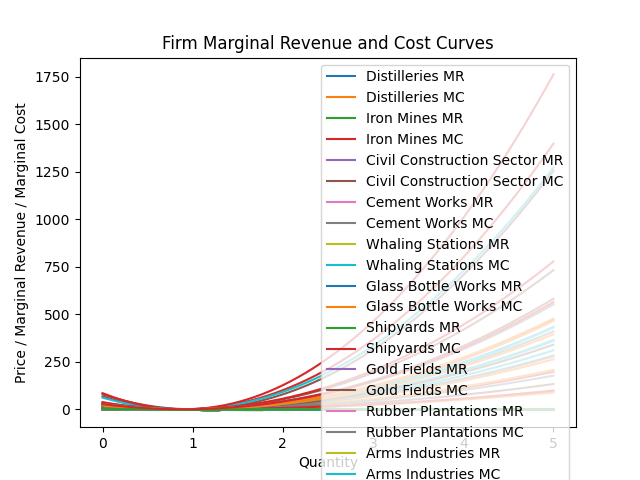

In [11]:
## PlOT
x = np.linspace(0, 5, 500)

plt.figure()
for firm in firmDefinitions:
    dCurve = firm.curves.demandCurve
    sCurve = firm.curves.supplyCurve

    mr = dCurve.M_R(x)
    mc = sCurve.M_C(x)

    # Include the firm's name in the label
    plt.plot(x, mr, label=f"{firm.name} MR")
    plt.plot(x, mc, label=f"{firm.name} MC")

    print(f"{firm.name} final ScaleOfProduction: {firm.scaleOfProduction[-1]}.")

plt.xlabel("Quantity")
plt.ylabel("Price / Marginal Revenue / Marginal Cost")
plt.title("Firm Marginal Revenue and Cost Curves")
plt.legend()  # show labels
plt.show()

grain final price: 0.5272584791157141.
coal final price: 0.6895781524213361.
iron final price: 0.8870271409775642.
lead final price: 0.1832712200520021.
sulfur final price: 0.5989837156506915.
gold final price: 0.19588123870175536.
wood final price: 0.974862267894124.
fish final price: 0.1851411263852392.
meat final price: 0.39664445282777755.
oil final price: 0.34175538361165214.
paper final price: 0.6830560926273613.
rubber final price: 0.18453805190062633.
fertilizer final price: 0.5556868359439338.
dye final price: 0.38704652653635646.
fabric final price: 0.7114516721771058.
clothes final price: 1.6370123975080824.
groceries final price: 0.9241333971267136.
furniture final price: 0.7746170279477887.
glass final price: 0.7682483859936832.
steel final price: 1.1865766324702023.
tools final price: 0.5016099846982826.
automobiles final price: 2.087707509156656.
munitions final price: 0.3694180617969469.
firearms final price: 0.5917134643705593.
artillery final price: 0.96158769856981.


<ipython-input-12-045fa43f2991>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


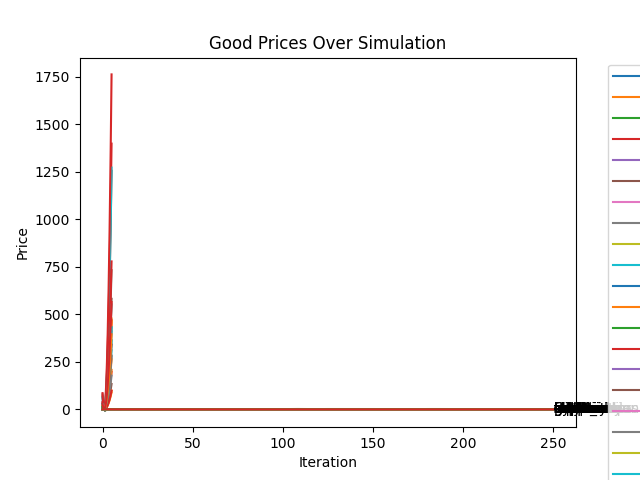

In [12]:
# plt.figure()
a = np.arange(0, simulationIterations + 1)

for good in goods:
    p = np.array(goods[good].price)
    # slice safely if arrays are longer than iterations
    plt.plot(a, p, label=f"{good} Price (smoothed)")
    print(f"{good} final price: {p[-1]}.")
    plt.text(a[-1], p[-1], good, va = 'center', ha = 'left')

plt.xlabel("Iteration")
plt.ylabel("Price")
plt.title("Good Prices Over Simulation")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
for firm in firmDefinitions:
    print(firm.curves.CalculateMarginalProfit(firm.scaleOfProduction[-1]) * firm.scaleOfProduction[-1])

-0.5147145838186447
-0.08163023673035774
-3.404254197380651
-1.628176684566421
2.2018578798671635e-12
-1.5360805702730367
-8.21857866532087
-0.000976535398418534
-1.745034543822608e-13
-3.2477702664973087
-2.799162395803792
-1.1493716365240725
-11.199463869496759
-0.000968105358824715
-7.417488071969237
-0.0074788474261555365
-0.04375907172042118
-0.7735336857803654
-2.3788861139669684
-2.083488348251213
-1.2102179505793522
-10.345748506538243
-0.018330188700843946
-0.000976535398418534
-1.8120202864713308
0.00502808460235832
-4.168936869286656
-4.276563806747802
-1.646750048776805
-0.012910857600834125
-0.012464148587498048
-4.535791596725602
-1.7676434561651376e-12
-3.215672355269468
-2.5247309766437422
-0.5717782937149658
6.612216867104107e-13
-0.0007314076037568594
-1.0313782477070956
-0.006518535232802947
-2.7223548787524074
-0.5716664471838792
-1.9912864489141044
-1.2561489937954283e-13
-3.842032058078749
-2.308675763069171
-3.2817105787493452
